In [3]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

import math

import copy
import pylab
import time
import sys
import sklearn.neighbors
import scipy.optimize
import random

# Méthode "Iterative Closest Point"

## 1.Problème:

Dans le nuage des points obtenu par lidar, on peut obtenir des clusters par DBSCANS. Notre objective est de trouver les clusters qui rassemblent à notre balise.

### Première approche

En premier temps, nous allons appliquer le méthode d'ICP. Le principe de cette méthode est de calculer la transformation optimale (composée d'une rotation et d'une translation) minimisant un critère de distance entre 2 nuage de points. Nous avons construit un dataset de balises en différent distance (). Nous allons l'utiliser comme le standard pour comparer. 

### Modélisation le problème

Soit $M_k$ notre kième cluster. Selon la distance de ce cluster, on choisi le standard S pour comparer.
Notre problème s'écrit:

$ min_{T \in \mathcal{T}} || T(M_k)-S|| $

où $\mathcal{T}$ est l'ensemble des transformation composée d'une rotation et d'une translation


In [4]:
#Notre nuage de point: 
# Loading dataset
df = pd.read_csv('Data/data.csv')
pd.options.display.max_rows = 100
NB_SAMPLES = 20

# Error corecction
x = df['x']
df['x'] = df['angle']
df['angle'] = x

y = df['y']
df['y'] = df['dist']
df['dist'] = y

df=df[:][:583]
# Dbscan Clustering
clustering = DBSCAN(eps=50, min_samples=3).fit_predict(df[['x','y']])

# angle / distance

df['clus']=clustering

nb_clus=len(np.unique(clustering))
clus=[]
for i in np.unique(clustering):
    clus.append(df[df['clus']==i][['x','y']])

In [5]:
clus[0].to_numpy().T

array([[-2035.71908904, -2042.32068634, -2691.51292538, -2779.2006091 ,
        -4397.59026042, -3512.26091496, -3460.55138801, -3417.72613914,
        -2021.68575201, -2097.42358262, -1360.67642352, -1337.63202827,
         -917.0708065 ,  -627.25155769,  -836.31417705,   285.31689671,
          708.83953719],
       [ -932.18495509,  -920.06859208,  -534.12935935,  -533.80143723,
          111.3593347 ,   110.54078555,   130.20403572,   149.62966889,
         1232.96825593,  1296.90798251,  1866.72431561,  1883.30575238,
         1360.83141347,  1525.04310869,  2069.3966747 ,   367.17743456,
          215.93404205]])

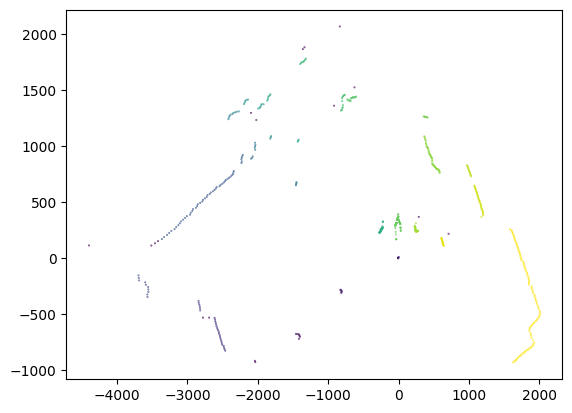

In [6]:
plt.scatter(df['x'],df['y'],c = clustering, marker='.', s=.5)
plt.show()

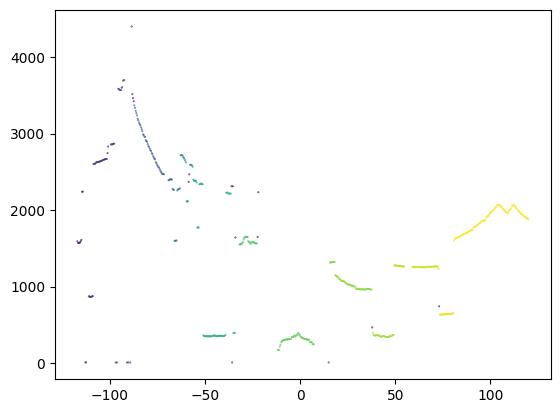

In [7]:
plt.scatter(df['angle'],df['dist'],c = clustering, marker='.', s=.5)
plt.show()

In [8]:
nb_clus

31

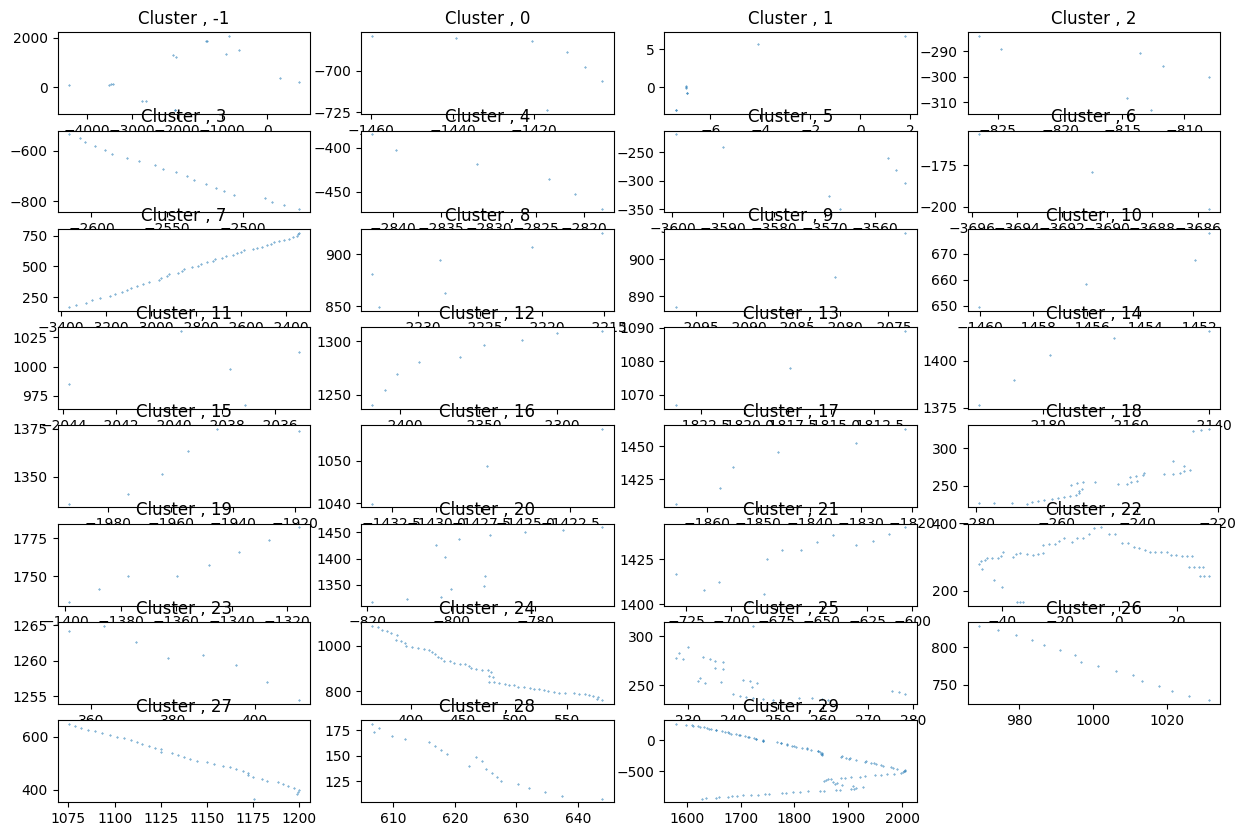

In [9]:
fig = plt.figure(figsize = (15,10))
for i in range(nb_clus):
    plt.subplot(int(nb_clus/4)+1,4,i+1)
    plt.scatter(clus[i]['x'],clus[i]['y'], marker='.', s=.5)
    plt.title("Cluster , {cl}".format(cl=i-1))
    

## 2. Algorithm ICP

Notre transformation s'écrit:

$\binom{x'}{y'}=\binom{cos \theta \ \ \ -sin \theta}{sin \theta \ \ \ cos \theta} \binom{x}{y} + \binom{a}{b} $

(x',y') point dans le nuage standard, (x,y) point dans le cluster

Algo:

+ Step 0: Considérons le k-ieme cluster en le diamètre d par le centre est notre lidar (notre robot). On va le comparer avec le standard $S_d$

+ Step 1: Algorithm ICP

Soient $u_i=(x_i',y_i') $ et $v_i=(x_i,y_i) $ ième point dans le standard et le nuage pour $i=1,...,N$ (N:nombre de points dans le nuage) ,

Notre problème à minimiser

$\sum_{i=1}^N ||T(v_i)-u_i||²$


In [23]:
def transformation(theta,a,b,nuage):
    #nuage: 
    W=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    d=W.dot(nuage)
    return d

In [72]:
#Code from Kaggel
#link https://www.kaggle.com/code/demetrypascal2/icp-algorithm-test/notebook

def icp(a, b,
        max_time = 1
    ):


    def res(p,src,dst):
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = np.sum(np.square(d[:,0])+np.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = np.matrix([[-np.sin(p[2]),-np.cos(p[2])],
                            [ np.cos(p[2]),-np.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = np.array([  np.sum(2*d[:,0]),
                        np.sum(2*d[:,1]),
                        np.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = np.size(src,0)
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = np.matrix([[-np.sin(p[2]),-np.cos(p[2])],[np.cos(p[2]),-np.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = np.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = np.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = np.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = np.matrix([[-np.cos(p[2]), np.sin(p[2])],[-np.sin(p[2]),-np.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = np.sum(2*(np.square(dUdth[:,0])+np.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = np.array([a.T], copy=True).astype(np.float32)
    dst = np.array([b.T], copy=True).astype(np.float32)
    Tr = np.array([[np.cos(init_pose[2]),-np.sin(init_pose[2]),init_pose[0]],
                   [np.sin(init_pose[2]), np.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",np.shape(src))
    print("Tr[0:2]",np.shape(Tr[0:2]))
    src = cv.transform(src, Tr[0:2])
    p_opt = np.array(init_pose)
    T_opt = np.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = np.array([[np.cos(p[2]),-np.sin(p[2]),p[0]],[np.sin(p[2]), np.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*np.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv.transform(src, T)
        Tr = (np.matrix(np.vstack((T,[0,0,1])))*np.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*np.pi)
    
    return T_opt, error_max

## 3. Tester le méthode avec les fausses données 

### Test 1

src (1, 8, 2)
Tr[0:2] (2, 3)
T [[ 0.7801374  -0.62560822  0.10096417]
 [ 0.62560822  0.7801374  -0.77998397]
 [ 0.          0.          1.        ]]
error 0.92604531833163
rotation° -38.72684290289389
dx 0.10096417017661564
dy -0.7799839749069045


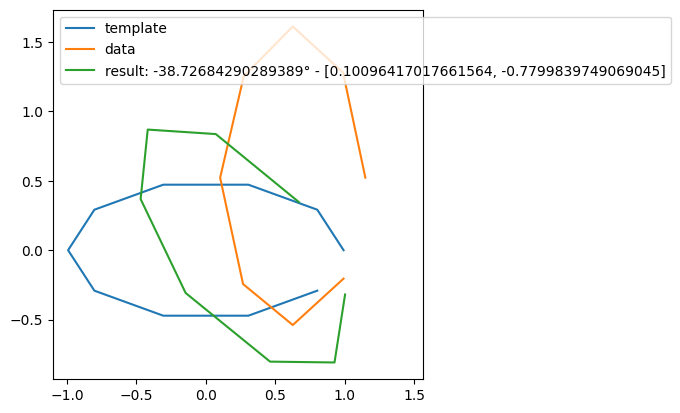

In [47]:
np.random.seed(0)
n1 = 10
n2 = 8
bruit = 1/10
center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
radius = random.random()
deformation = 2

template1 = np.array([
        [np.cos(i*2*np.pi/n1)*radius*deformation for i in range(n1)], 
        [np.sin(i*2*np.pi/n1)*radius for i in range(n1)]
    ])

data1 = np.array([
        [np.cos(i*2*np.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [np.sin(i*2*np.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    
    
T, error = icp(data1,template1)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

    
    
result = cv.transform(np.array([data1.T], copy=True).astype(np.float32), T).T
plt.plot(template1[0], template1[1], label="template")
plt.plot(data1[0], data1[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.axis('square')
plt.show()

### Test 2

           x         y
0  -0.200000  0.040334
1  -0.171429  0.030882
2  -0.142857  0.020203
3  -0.114286  0.013374
4  -0.085714  0.006493
5  -0.057143  0.000712
6  -0.028571  0.001470
7   0.000000  0.000864
8   0.028571  0.000074
9   0.057143  0.005535
10  0.085714  0.005893
11  0.114286  0.013107
12  0.142857  0.020221
13  0.171429  0.030921
14  0.200000  0.041469
src (1, 15, 2)
Tr[0:2] (2, 3)
T [[ 5.43982339e-01  8.39096666e-01  2.74624965e-02]
 [-8.39096666e-01  5.43982339e-01  9.62415644e-05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
error 0.0008519808992579011
rotation° 57.044852391301234
dx 0.02746249650698359
dy 9.62415643876776e-05


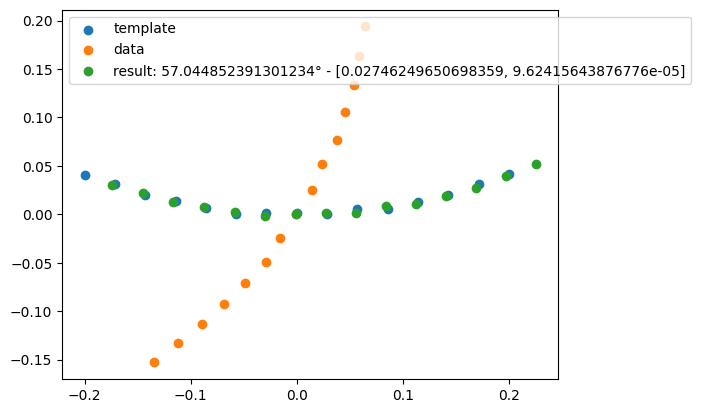

In [53]:
d = {'x': np.linspace(-0.2,0.2,15), 'y': (np.linspace(-0.2,0.2,15))**2+np.random.normal(0, 0.001,15)}
stand = pd.DataFrame(data=d)
print(stand)
template2=stand.T.to_numpy()
data2=transformation(np.pi/3,1,2,template2)

T, error = icp(data2,template2)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data2.T], copy=True).astype(np.float32), T).T
plt.scatter(template2[0], template2[1], label="template")
plt.scatter(data2[0], data2[1], label="data")
plt.scatter(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()

src (1, 8, 2)
Tr[0:2] (2, 3)
T [[ 0.14974326  0.98872491 -2.83443542]
 [-0.98872491  0.14974326  2.32408434]
 [ 0.          0.          1.        ]]
error 0.012929071991623126
rotation° 81.38795175848054
dx -2.834435421650473
dy 2.3240843354793026


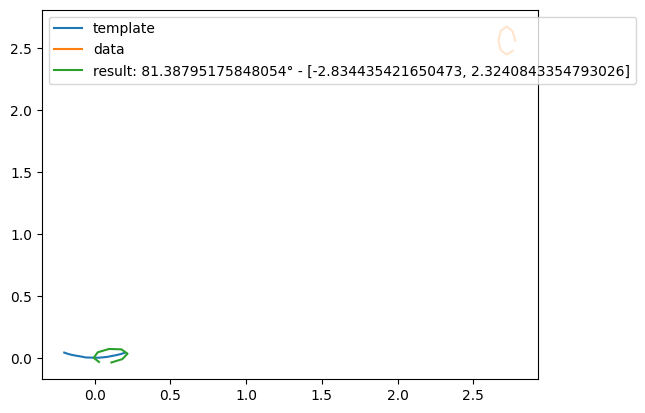

In [27]:
T, error = icp(data1,template2)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data1.T], copy=True).astype(np.float32), T).T
plt.plot(template2[0], template2[1], label="template")
plt.plot(data1[0], data1[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()

src (1, 15, 2)
Tr[0:2] (2, 3)
T [[ 0.53379613  0.8456132   0.00773155]
 [-0.8456132   0.53379613 -0.03778615]
 [ 0.          0.          1.        ]]
error 0.03300598265209055
rotation° 57.73769535130928
dx 0.007731549512864443
dy -0.03778615483341128


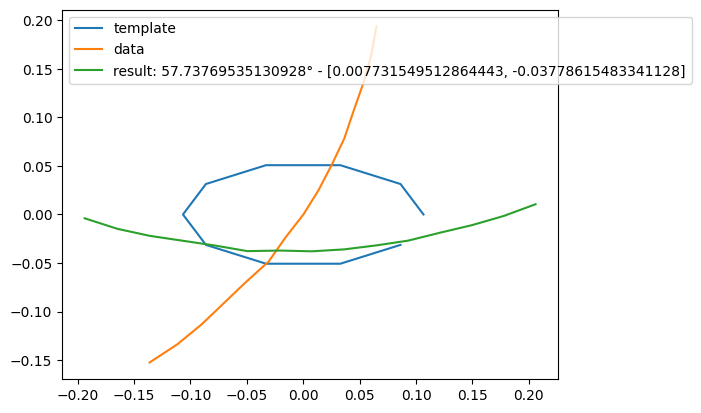

In [28]:
T, error = icp(data2,template1)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data2.T], copy=True).astype(np.float32), T).T
plt.plot(template1[0], template1[1], label="template")
plt.plot(data2[0], data2[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()

## 4. Tester le méthode avec les vraies données

In [75]:
# Import nuage M (images LIDAR)
df = pd.read_csv('Data/data_x=120cm_y=0cm.csv')
M = df[df['sample']==0]
M = M[['x','y']]
print(M)

# Clustering en k nuages (M_k)
def clustering_dbscan (M) :
    clustering = DBSCAN(eps=50, min_samples=3).fit_predict(M[['x','y']])

    M['clus']=clustering

    nb_clus=len(np.unique(clustering))
    clus=[]
    for i in np.unique(clustering):
        clus.append(M[M['clus']==i][['x','y']])
    return clus, nb_clus
    
# Import nuages S (balise)
S = pd.read_csv('Train_dataset/standard_balise_data_x=120cm_y=0cm.csv')
S = S[['x','y']].T.to_numpy()
print(S)

# ICP sur 1 cluster M_k
def icp_cluster (data, template) :
    T, error = icp(data,template)
    return T, error

# ICP sur chaque cluster M_k
def icp_nuage (M, S) :
    clus, nb_clus = clustering_dbscan(M)
    
    T = []
    error = []
    
    for k in range(nb_clus) :
        #print(clus[k])
        M_k = clus[k].T.to_numpy()
        #print(M_k)
        T_clus, error_clus = icp_cluster (M_k, S)
        T.append(T_clus)
        error.append(error_clus)
    return T, error

# Visualisation erreur
T, error = icp_nuage(M,S)
print(error)

# Seuil d'erreur


# Visualisation après seuil

               x            y
0      -3.487825    -6.069191
1    -374.551407 -1134.784668
2    -363.572395 -1124.695120
3    -354.542105 -1120.234304
4    -341.734090 -1103.287275
..           ...          ...
333  -198.376001  2501.145330
334    -1.023524     6.924767
335    -2.598105     6.499989
336    -2.992377     6.328166
337 -1201.216855  2461.544041

[338 rows x 2 columns]
[[1219. 1208. 1197. 1192. 1193. 1190. 1192. 1194. 1193. 1196. 1201. 1208.
  1229.]
 [-162. -153. -144. -136. -129. -121. -114. -107.  -99.  -92.  -85.  -78.
   -72.]]
src (1, 8, 2)
Tr[0:2] (2, 3)
src (1, 17, 2)
Tr[0:2] (2, 3)
src (1, 46, 2)
Tr[0:2] (2, 3)
src (1, 7, 2)
Tr[0:2] (2, 3)
src (1, 8, 2)
Tr[0:2] (2, 3)
src (1, 9, 2)
Tr[0:2] (2, 3)
src (1, 14, 2)
Tr[0:2] (2, 3)
src (1, 8, 2)
Tr[0:2] (2, 3)
src (1, 5, 2)
Tr[0:2] (2, 3)
src (1, 8, 2)
Tr[0:2] (2, 3)
src (1, 7, 2)
Tr[0:2] (2, 3)
src (1, 4, 2)
Tr[0:2] (2, 3)
src (1, 4, 2)
Tr[0:2] (2, 3)
src (1, 28, 2)
Tr[0:2] (2, 3)
src (1, 7, 2)
Tr[0:2] (2, 3)
src (1, 18

16


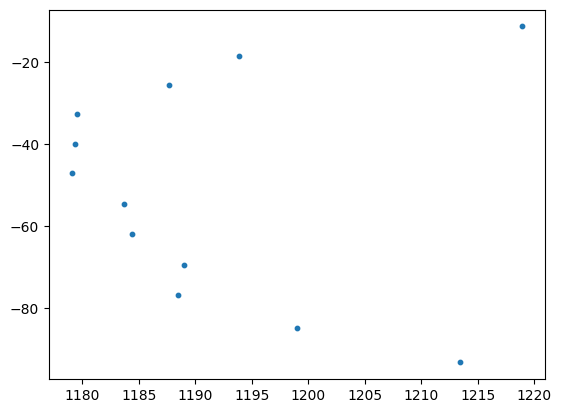

In [71]:
min_value = min(error)
min_index = error.index(min_value)
print(min_index)
plt.scatter(clus[min_index]['x'],clus[min_index]['y'], marker='o', s=10)